Plot PDF of surface precipitation rate for year-long prognostic runs and GPCP.

Generates Figure S4.

In [1]:
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
import fv3viz
import numpy as np
import os
from fv3net.diagnostics.prognostic_run import load_physics, get_verification_entries
from vcm.catalog import catalog
plt.rcParams['figure.dpi'] = 300
xr.set_options(keep_attrs=True)

In [2]:
urls = {
    'baseline': 'gs://vcm-ml-experiments/2020-10-30-nudge-to-obs-GRL-paper/baseline-run-2016',
    'ML-corrected': 'gs://vcm-ml-experiments/2021-03-15-nudge-to-obs-GRL-paper-rev1/rf-control/prognostic_run',
    'ML-corrected ($\Delta Q_1$, $\Delta Q_2$ only)': 'gs://vcm-ml-experiments/2021-03-15-nudge-to-obs-GRL-paper-rev1/rf-dQ1-dQ2-only/prognostic_run',
}

In [3]:
verif_entries = get_verification_entries('40day_may2020', catalog)
physics_diags = []
for run, url in urls.items():
    tmp, verif, grid = load_physics(url, verif_entries['physics'], catalog)
    variables_to_drop = [v for v in tmp.data_vars if v.endswith('_diagnostic')]
    physics_diags.append(tmp.drop_vars(variables_to_drop).assign_coords(experiment=run))
physics_diags = xr.concat(physics_diags, dim='experiment')
physics_diags = physics_diags.set_coords(['lon', 'lat', 'lonb', 'latb', 'area'])

In [4]:
def load_GPCP():
    url_gpcp = 'gs://vcm-ml-raw/2020-11-10-GPCP-2015-2016/gpcp_v01r03_daily.zarr'
    m = fsspec.get_mapper(url_gpcp)
    return xr.open_zarr(m, consolidated=True)

In [13]:
def precip_hist(data):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
    bins = np.logspace(-1, np.log10(500), 100)
    colors = ['k', 'r', 'b', 'y']

    ax.grid()
    for i, (label, da) in enumerate(data.items()):
        ax.hist(da.values.flatten(), bins=bins, histtype='step', label=label, density=True, color=colors[i])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('mm/day')
    ax.set_ylabel('Frequency [(mm/day)**-1]')
    ax.set_xlim([np.min(bins), np.max(bins)])
    ax.legend(loc=3)

In [6]:
start_time = physics_diags.time.values[0].isoformat()
end_time = physics_diags.time.values[-1].isoformat()

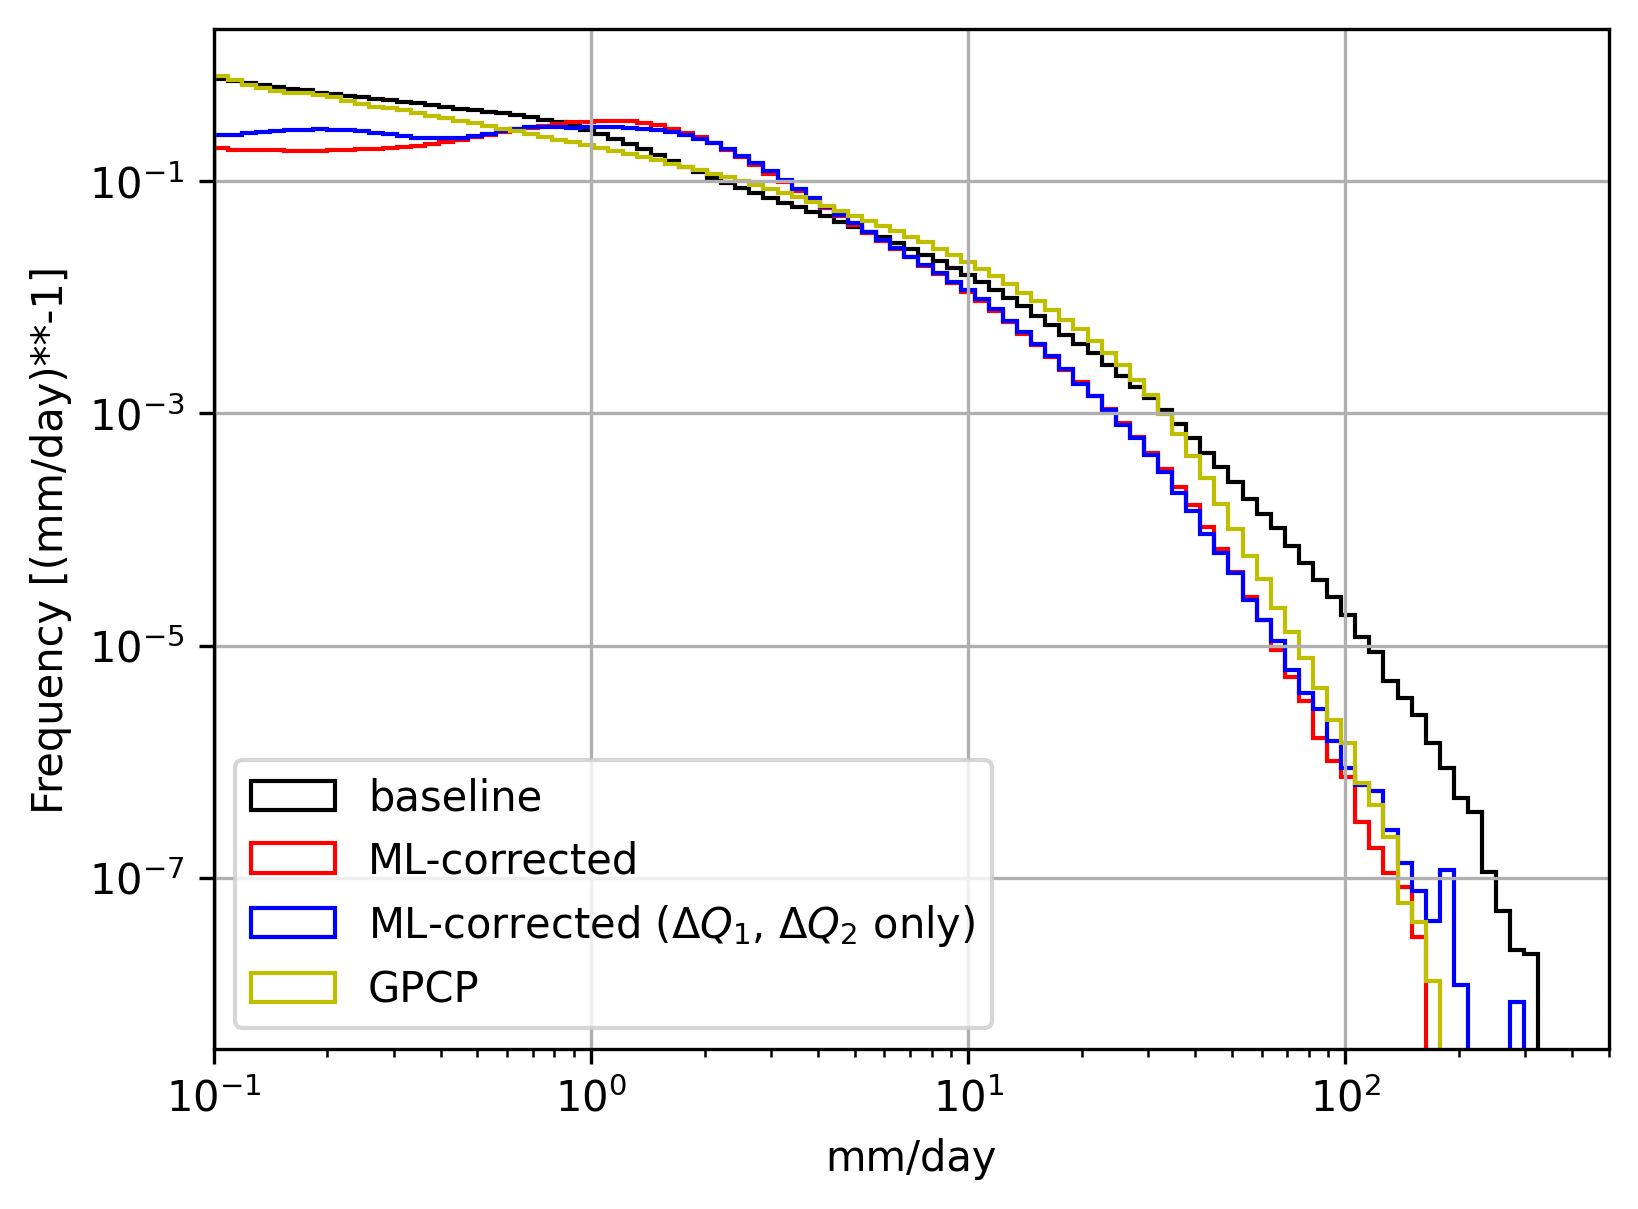

In [14]:
gpcp_precip = load_GPCP()
data = {}
for exp in physics_diags.experiment.values:
    data[exp] = physics_diags.total_precip_to_surface.sel(experiment=exp)
    data[exp] = data[exp].rolling(time=8).mean().isel(time=slice(None, None, 8))
data['GPCP'] = gpcp_precip.precip.sel(time=slice(start_time, end_time))

precip_hist(data)